In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

168


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,177391d1391156fbd525e4fcd99fba991e9178b5,loony-berk,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format.txt,cq.txt,standard-2-shot.json,...,0.210000,0.297744,0.27,0.366239,0.24,0.318766,0.12,0.208228,Standard,2
1,4ce51d7185befed6bcfeabe4ed2202e8968a5c3c,filar-duke,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format.txt,cq.txt,empty.json,...,0.206667,0.292214,0.21,0.337016,0.26,0.322345,0.15,0.217281,Standard,0
2,8fcdc9286cda2c1d442f504a40bf17ed88578d1a,catty-curb,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format.txt,cq.txt,standard-2-shot.json,...,0.230000,0.320007,0.23,0.337095,0.25,0.347237,0.21,0.275689,Standard,2
3,6ae8b97043204637fac39dd958cad633472a5387,shock-jump,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format.txt,cq.txt,empty.json,...,0.223333,0.312181,0.32,0.431108,0.19,0.256472,0.16,0.248964,Standard,0
4,bb812c86f9ae256834ec7cc40f3b53aaa0e38d0c,beady-coze,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,standard/minimal-output-format-few.txt,cq.txt,standard-2-shot.json,...,0.296667,0.382108,0.30,0.394228,0.30,0.394629,0.29,0.357468,Standard,2


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [4]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.n_shot",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [5]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples", "params.qa.temperature"])[
        "params.run"
    ]
    .aggregate(tuple)
    .reset_index()
)
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run


In [6]:
def remove_ext(filename):
    return filename.replace(".txt", "")

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)

## Statistical Testing

In [7]:
# Filter out experiments with F1 score < 0.1
df_filtered = df[df['metrics.f1'] >= 0.1].copy()
df_filtered.shape

(168, 15)

In [8]:
df_filtered

,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,0.1,standard/excellent-few,cq,empty.json,1,0.533333,0.651896,0.62,0.725316,0.55,0.678190,0.43,0.552183,Standard,0
1,0.1,standard/excellent-few,cq,empty.json,2,0.526667,0.645452,0.61,0.720316,0.54,0.666857,0.43,0.549183,Standard,0
2,0.1,standard/excellent-few,cq,empty.json,3,0.533333,0.649563,0.62,0.725316,0.55,0.674190,0.43,0.549183,Standard,0
3,0.3,standard/excellent-few,cq,empty.json,1,0.533333,0.647896,0.63,0.730316,0.55,0.674190,0.42,0.539183,Standard,0
4,0.3,standard/excellent-few,cq,empty.json,2,0.533333,0.650516,0.62,0.725316,0.55,0.668857,0.43,0.557374,Standard,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.5,standard/minimal-output-format,cq,standard-2-shot.json,2,0.513333,0.631512,0.55,0.682954,0.54,0.640499,0.45,0.571083,Standard,2
164,1.5,standard/minimal-output-format,cq,standard-2-shot.json,3,0.500000,0.610332,0.57,0.690482,0.47,0.579012,0.46,0.561503,Standard,2
165,2.0,standard/minimal-output-format,cq,standard-2-shot.json,1,0.270000,0.364317,0.30,0.404302,0.32,0.418560,0.19,0.270088,Standard,2
166,2.0,standard/minimal-output-format,cq,standard-2-shot.json,2,0.230000,0.320007,0.23,0.337095,0.25,0.347237,0.21,0.275689,Standard,2


In [9]:
df_filtered['params.qa.system_prompt'].unique()

array(['standard/excellent-few', 'standard/helpful-output-format-few',
       'standard/minimal-output-format-few',
       'standard/minimal-output-format'], dtype=object)

In [13]:
def prepare_data_for_anova(dataf, technique):
    metric_column='metrics.f1'
    
    # Filter data for the specified technique
    filtered_data = dataf[dataf['params.qa.technique'] == technique]

    if filtered_data.empty:
        raise ValueError(f"No data available for technique: {technique}")

    # Simplify column names for use in formula
    filtered_data = filtered_data.rename(columns={
        'params.qa.temperature': 'temperature',
        'params.qa.system_prompt': 'system_prompt',
        'params.qa.user_prompt_template': 'user_prompt',
        "params.qa.n_shot": "n_shot",
    })

    # Combine prompts into a single column for simplicity
    filtered_data['prompt'] = filtered_data['system_prompt'] + ' | ' + filtered_data['user_prompt'] + " | " + filtered_data['n_shot'].map(str)

    return filtered_data[['temperature', 'prompt', 'params.run', metric_column]].rename(columns={metric_column: 'f1'})

def two_way_anova(dataf):
    # Perform Two-Way ANOVA with replication
    formula = 'f1 ~ C(prompt) + C(temperature) + C(prompt):C(temperature)'
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)

def one_way_anova_by_temperature(dataf):
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf['temperature'].unique()
    for temp in temperatures:
        temp_data = dataf[dataf['temperature'] == temp]
        grouped = temp_data.groupby('prompt')['f1'].apply(list).reset_index()
        f1_scores = grouped['f1']

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")

def visualize_results(dataf):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='temperature', y='f1', hue='prompt', data=dataf)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    plt.legend(title="Prompt", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

prepared_data = prepare_data_for_anova(df_filtered, technique='Standard')


In [14]:
# Two-Way ANOVA
two_way_anova(prepared_data)

Two-Way ANOVA Results:
                            sum_sq     df            F         PR(>F)
C(prompt)                 0.130671    7.0   158.726647   4.349979e-55
C(temperature)            1.917776    6.0  2717.782549  8.122270e-119
C(prompt):C(temperature)  0.008236   42.0     1.667291   1.787888e-02
Residual                  0.013172  112.0          NaN            NaN


In [15]:
# Perform One-Way ANOVA by Temperature
one_way_anova_by_temperature(prepared_data)

One-Way ANOVA for Temperature 0.1:
F-statistic: 250.3636, p-value: 3.9057e-15
One-Way ANOVA for Temperature 0.3:
F-statistic: 235.6695, p-value: 6.2999e-15
One-Way ANOVA for Temperature 0.5:
F-statistic: 123.0278, p-value: 1.0444e-12
One-Way ANOVA for Temperature 0.7:
F-statistic: 24.7002, p-value: 1.9346e-07
One-Way ANOVA for Temperature 1.0:
F-statistic: 18.7800, p-value: 1.3243e-06
One-Way ANOVA for Temperature 1.5:
F-statistic: 21.3543, p-value: 5.4194e-07
One-Way ANOVA for Temperature 2.0:
F-statistic: 11.5271, p-value: 3.3567e-05


In [27]:
# Tukey’s HSD
temperature_mask = prepared_data['temperature'] <= 1.0
_data = prepared_data.loc[temperature_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.005)
print(tukey)


                                     Multiple Comparison of Means - Tukey HSD, FWER=0.01                                      
                   group1                                      group2                   meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------------
            standard/excellent-few | cq | 0             standard/excellent-few | cq | 2   0.0354    0.0  0.0253  0.0455   True
            standard/excellent-few | cq | 0 standard/helpful-output-format-few | cq | 0   0.0148    0.0  0.0047  0.0249   True
            standard/excellent-few | cq | 0 standard/helpful-output-format-few | cq | 2   0.0448    0.0  0.0347  0.0549   True
            standard/excellent-few | cq | 0     standard/minimal-output-format | cq | 0  -0.0377    0.0 -0.0478 -0.0275   True
            standard/excellent-few | cq | 0     standard/minimal-output-format | cq | 2  -0.0051 0.5215 -0.0152

In [29]:
# Tukey’s HSD
temperature_mask = prepared_data['temperature'] <= 1.0
n_shot_mask = prepared_data['prompt'].str.endswith('0')
_data = prepared_data.loc[temperature_mask&n_shot_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.005)
print(tukey)


                                     Multiple Comparison of Means - Tukey HSD, FWER=0.01                                      
                   group1                                      group2                   meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------------
            standard/excellent-few | cq | 0 standard/helpful-output-format-few | cq | 0   0.0148    0.0  0.0067  0.0229   True
            standard/excellent-few | cq | 0     standard/minimal-output-format | cq | 0  -0.0377    0.0 -0.0458 -0.0295   True
            standard/excellent-few | cq | 0 standard/minimal-output-format-few | cq | 0    0.013    0.0  0.0049  0.0212   True
standard/helpful-output-format-few | cq | 0     standard/minimal-output-format | cq | 0  -0.0524    0.0 -0.0606 -0.0443   True
standard/helpful-output-format-few | cq | 0 standard/minimal-output-format-few | cq | 0  -0.0018 0.8745 -0.0099

In [30]:
# Tukey’s HSD
temperature_mask = prepared_data['temperature'] <= 1.0
n_shot_mask = prepared_data['prompt'].str.endswith('0')
_data = prepared_data.loc[temperature_mask&~n_shot_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.005)
print(tukey)


                                     Multiple Comparison of Means - Tukey HSD, FWER=0.01                                      
                   group1                                      group2                   meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------------
            standard/excellent-few | cq | 2 standard/helpful-output-format-few | cq | 2   0.0094 0.0109 -0.0008  0.0196  False
            standard/excellent-few | cq | 2     standard/minimal-output-format | cq | 2  -0.0405    0.0 -0.0507 -0.0304   True
            standard/excellent-few | cq | 2 standard/minimal-output-format-few | cq | 2   0.0061 0.1626  -0.004  0.0163  False
standard/helpful-output-format-few | cq | 2     standard/minimal-output-format | cq | 2    -0.05    0.0 -0.0602 -0.0398   True
standard/helpful-output-format-few | cq | 2 standard/minimal-output-format-few | cq | 2  -0.0033 0.6787 -0.0135

## Visualizations

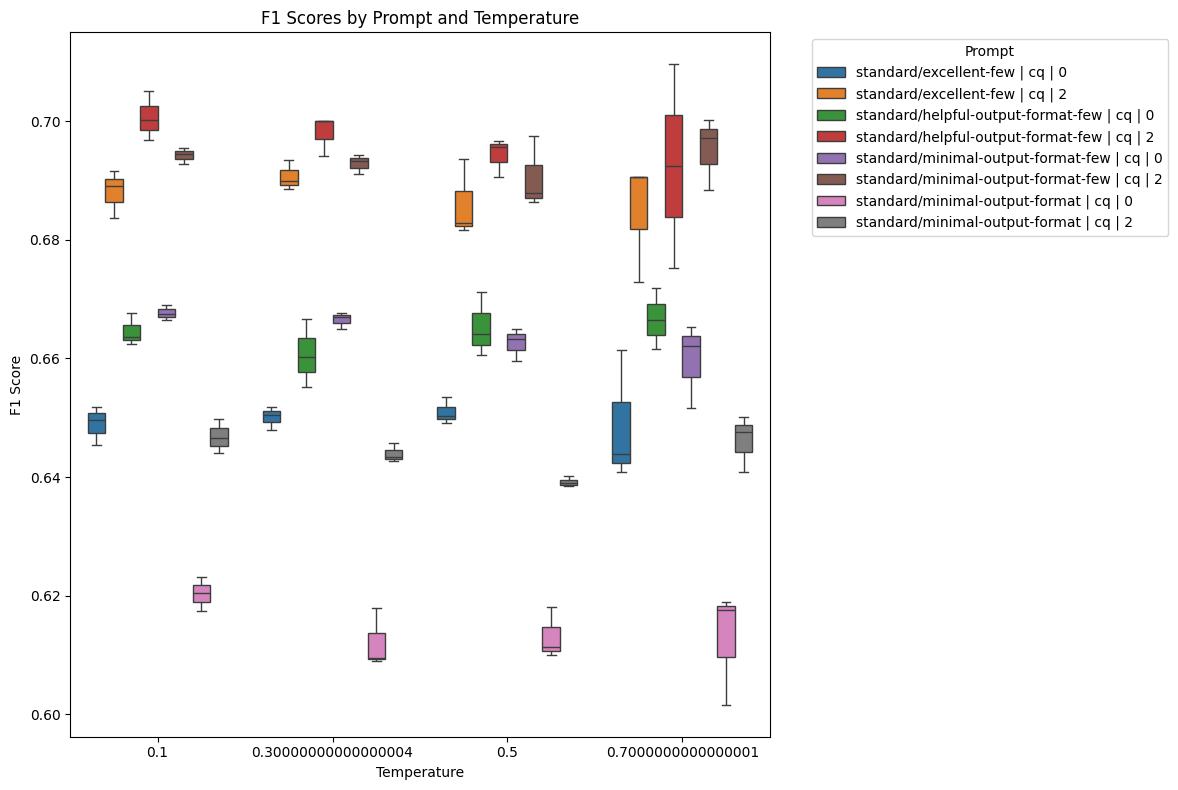

In [17]:
# Visualize Results
temperature_mask = prepared_data['temperature'] < 1.0
visualize_results(prepared_data.loc[temperature_mask])


In [18]:
def plot_variance(dataf, figsize=(8, 8), legend_loc='lower left'):
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='prompt', data=dataf, linewidth=2.5)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    plt.legend(title="Prompt", loc=legend_loc)
    plt.tight_layout()
    plt.show()

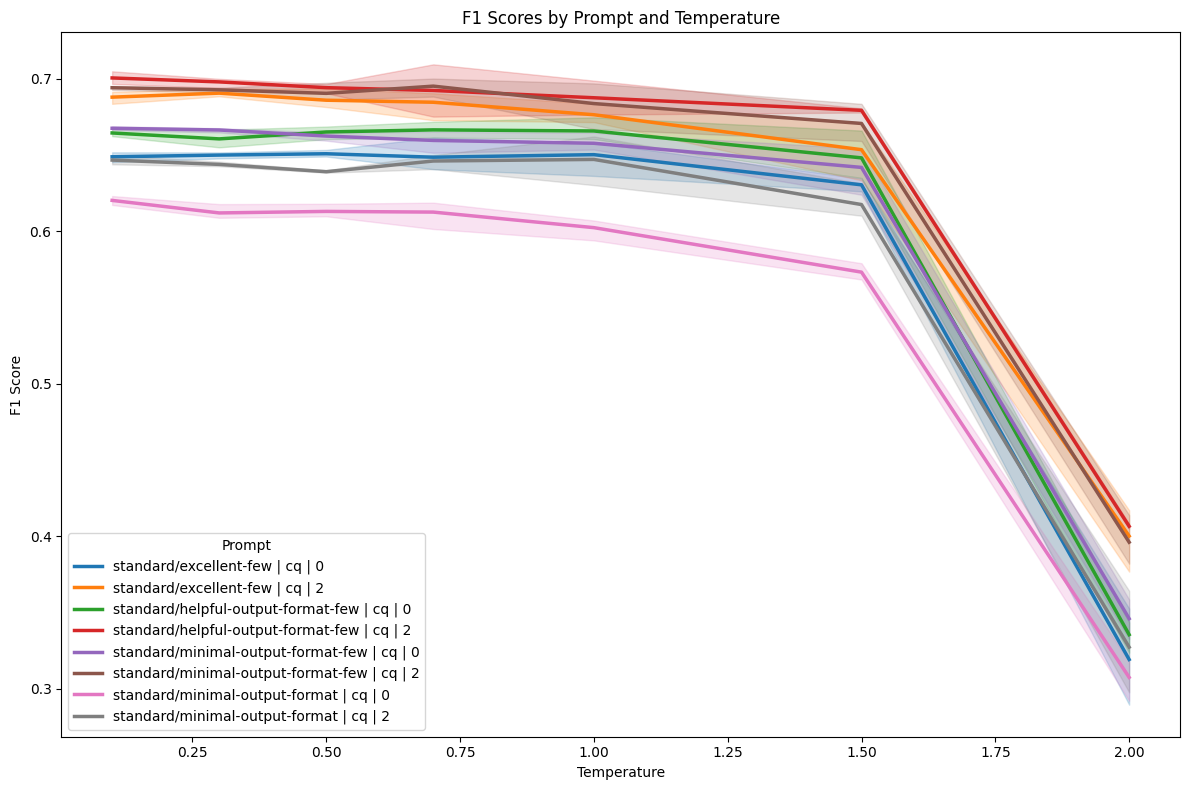

In [19]:
plot_variance(prepared_data, figsize=(12, 8))

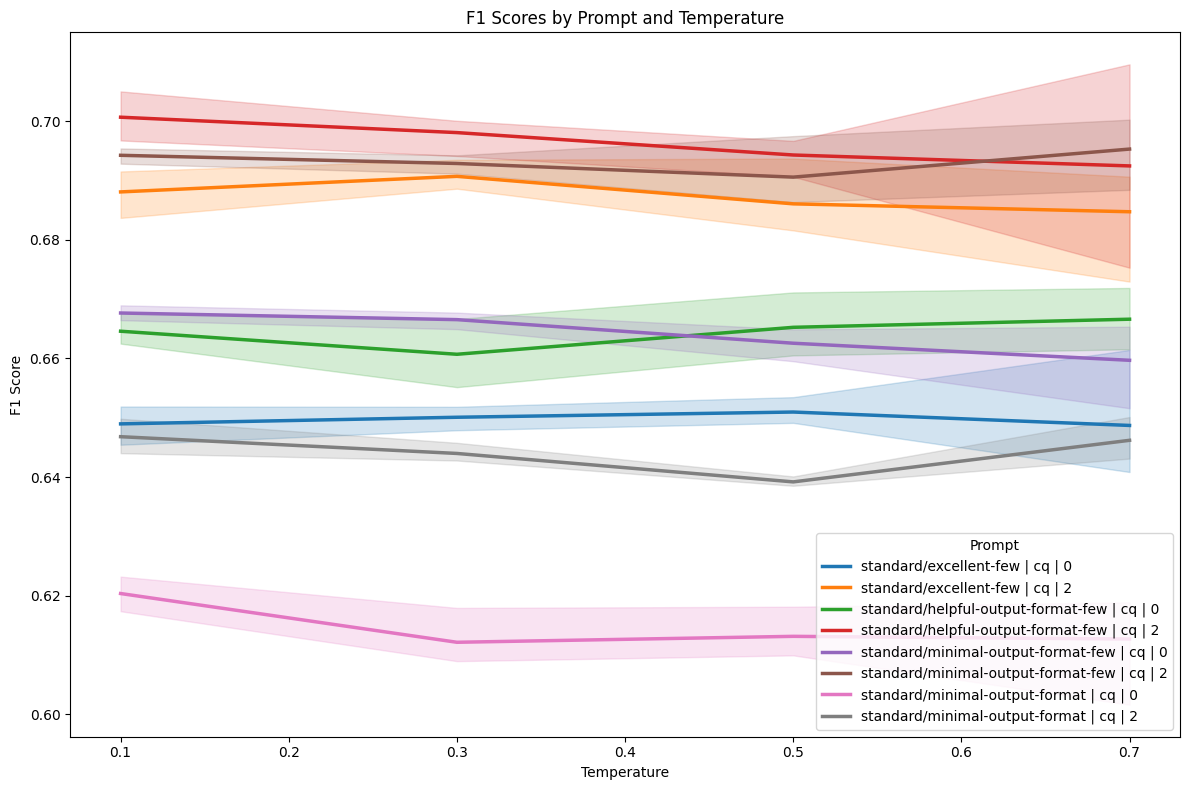

In [20]:
temperature_mask = prepared_data['temperature'] < 1.0
plot_variance(prepared_data.loc[temperature_mask], figsize=(12, 8), legend_loc='lower right')

In [22]:
temperature_mask = prepared_data["temperature"] <= 1.0
prompt_f1 = prepared_data.loc[temperature_mask].groupby(["prompt"])["f1"].describe()
prompt_f1.sort_values(by="mean", ascending=False, inplace=True)
prompt_f1

,count,mean,std,min,25%,50%,75%,max
prompt,,,,,,,,
standard/helpful-output-format-few | cq | 2,15.0,0.694645,0.009330,0.675305,0.691572,0.696686,0.700057,0.709593
standard/minimal-output-format-few | cq | 2,15.0,0.691380,0.007884,0.667196,0.688156,0.693228,0.696250,0.700268
standard/excellent-few | cq | 2,15.0,0.685230,0.007398,0.671699,0.682257,0.688629,0.690629,0.693702
standard/helpful-output-format-few | cq | 0,15.0,0.664614,0.005200,0.655162,0.661066,0.663569,0.667181,0.674831
standard/minimal-output-format-few | cq | 0,15.0,0.662862,0.005444,0.651608,0.660824,0.664916,0.666714,0.668958
standard/excellent-few | cq | 0,15.0,0.649819,0.006499,0.636418,0.646674,0.650288,0.652687,0.661435
standard/minimal-output-format | cq | 2,15.0,0.644685,0.007141,0.630397,0.640497,0.644033,0.648322,0.662273
standard/minimal-output-format | cq | 0,15.0,0.612169,0.007938,0.594131,0.608069,0.611363,0.618037,0.623213


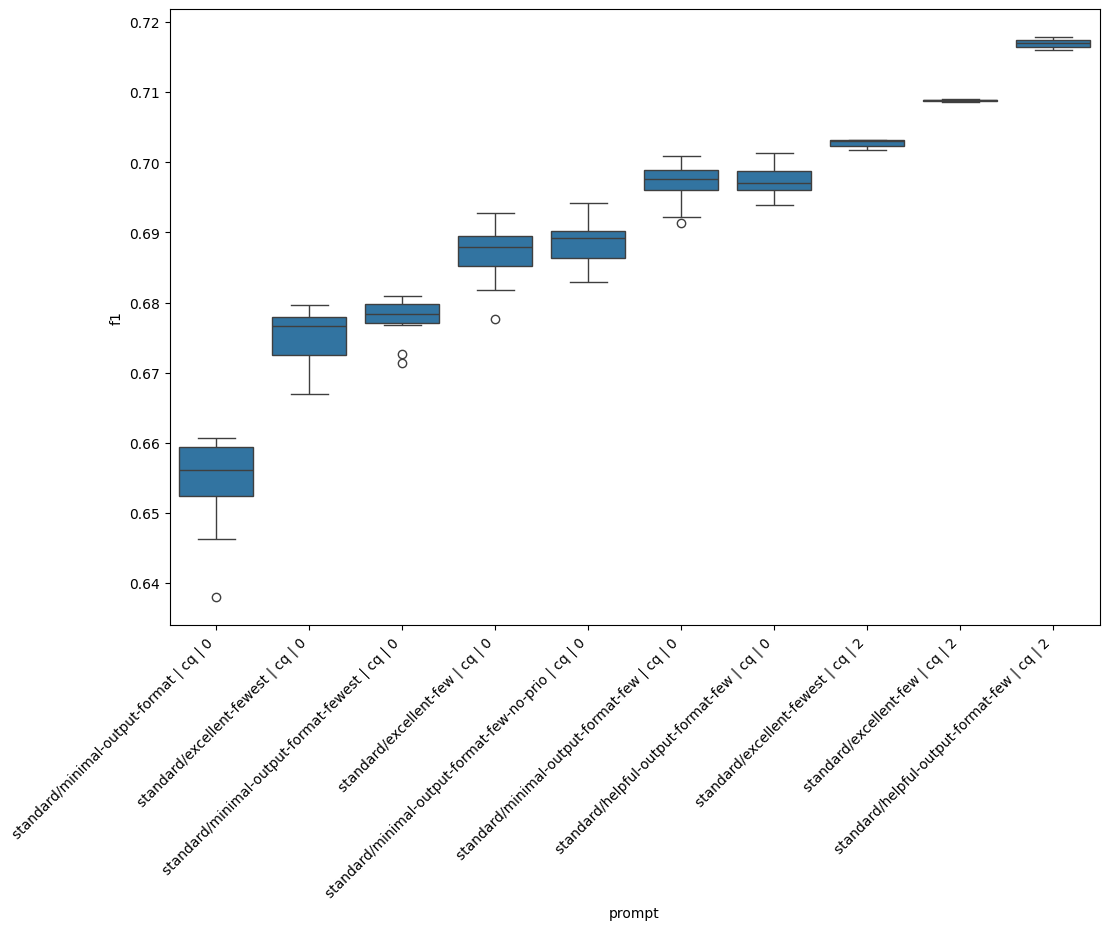

In [18]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_data.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=45, ha="right");